## 走神司机监测项目数据探索

### 1. 基本的数据集信息

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

data_dir = r'D:\dataset\DistractedDriver'
data_path = Path(data_dir)


In [2]:
test_pic = [p for p in (data_path / 'test').iterdir()]
print('samples of test:', len(test_pic))

samples of test: 79726


In [3]:
classes = ['c'+str(i) for i in range(10)]
classes_paths = [data_path / 'train' / nm for nm in classes]
classes_counts = {p.stem: len(list(p.iterdir())) for p in classes_paths}

In [4]:
classes_counts

{'c0': 2489,
 'c1': 2267,
 'c2': 2317,
 'c3': 2346,
 'c4': 2326,
 'c5': 2312,
 'c6': 2325,
 'c7': 2002,
 'c8': 1911,
 'c9': 2129}

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

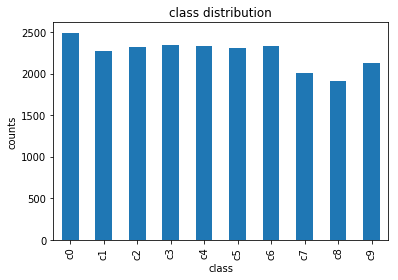

In [6]:
ax = pd.Series(classes_counts).plot(kind='bar', title='class distribution')
ax.set_xlabel('class')
ax.set_ylabel('counts')
ax

In [7]:
n_train = np.sum(list(classes_counts.values()))
print('samples of train:', n_train)

samples of train: 22424


In [8]:
driver_imgs = pd.read_csv(str(data_path/'driver_imgs_list.csv'))

In [9]:
driver_imgs.head()

subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

In [10]:
drivers = driver_imgs.subject.unique()
n_drivers = len(drivers)
print('drivers:', drivers)
print('n_drivers:', n_drivers)

drivers: ['p002' 'p012' 'p014' 'p015' 'p016' 'p021' 'p022' 'p024' 'p026' 'p035'
 'p039' 'p041' 'p042' 'p045' 'p047' 'p049' 'p050' 'p051' 'p052' 'p056'
 'p061' 'p064' 'p066' 'p072' 'p075' 'p081']
n_drivers: 26


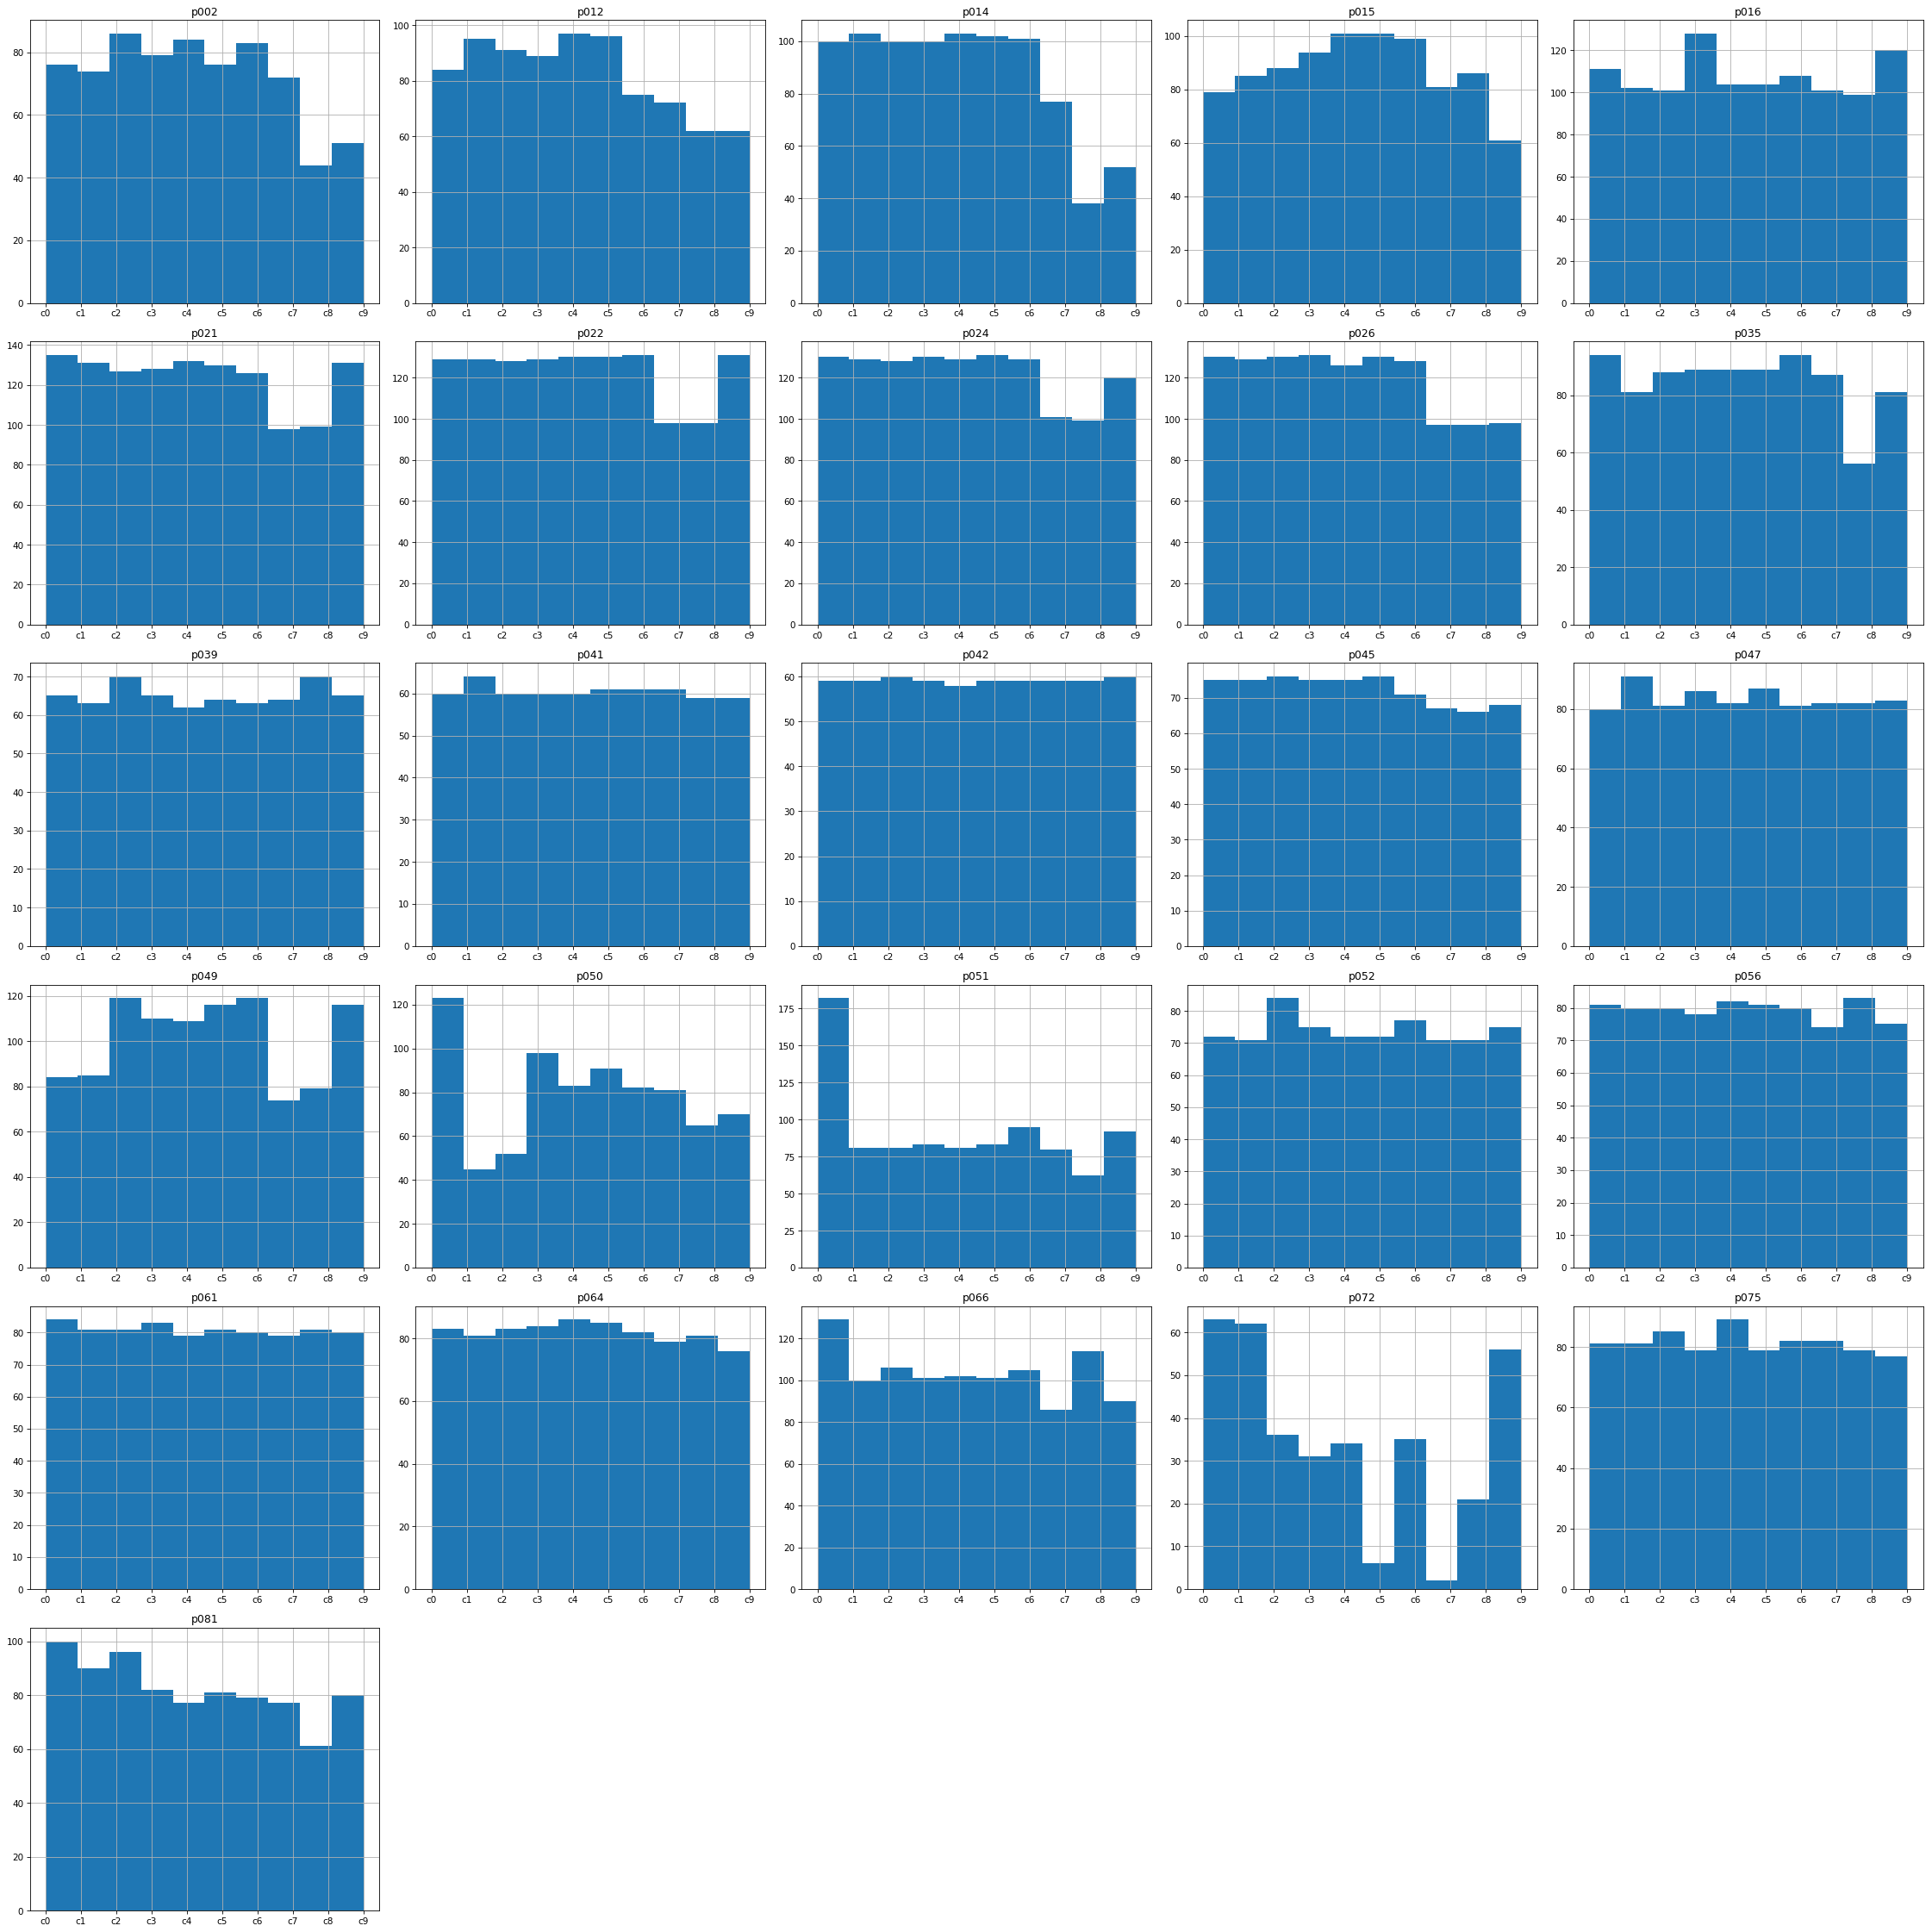

In [11]:
drivers_group = driver_imgs.groupby(['subject'])
fig = plt.figure(figsize=(30,30),dpi=75)
for i,driver_name in enumerate(drivers):
    ax = plt.subplot(6, 5, i+1)
    drivers_group.get_group(driver_name)['classname'].hist()
    ax.set_title(driver_name)
    fig.tight_layout()


### 数据集总结
- 分类数：10
- 训练集：总共有22424个样本，每个类的分布大致均匀。包括26个司机。
- 测试集：总共有79726个样本，每个类的分布未知，测试集有更多的司机。

### 2. 观察图片

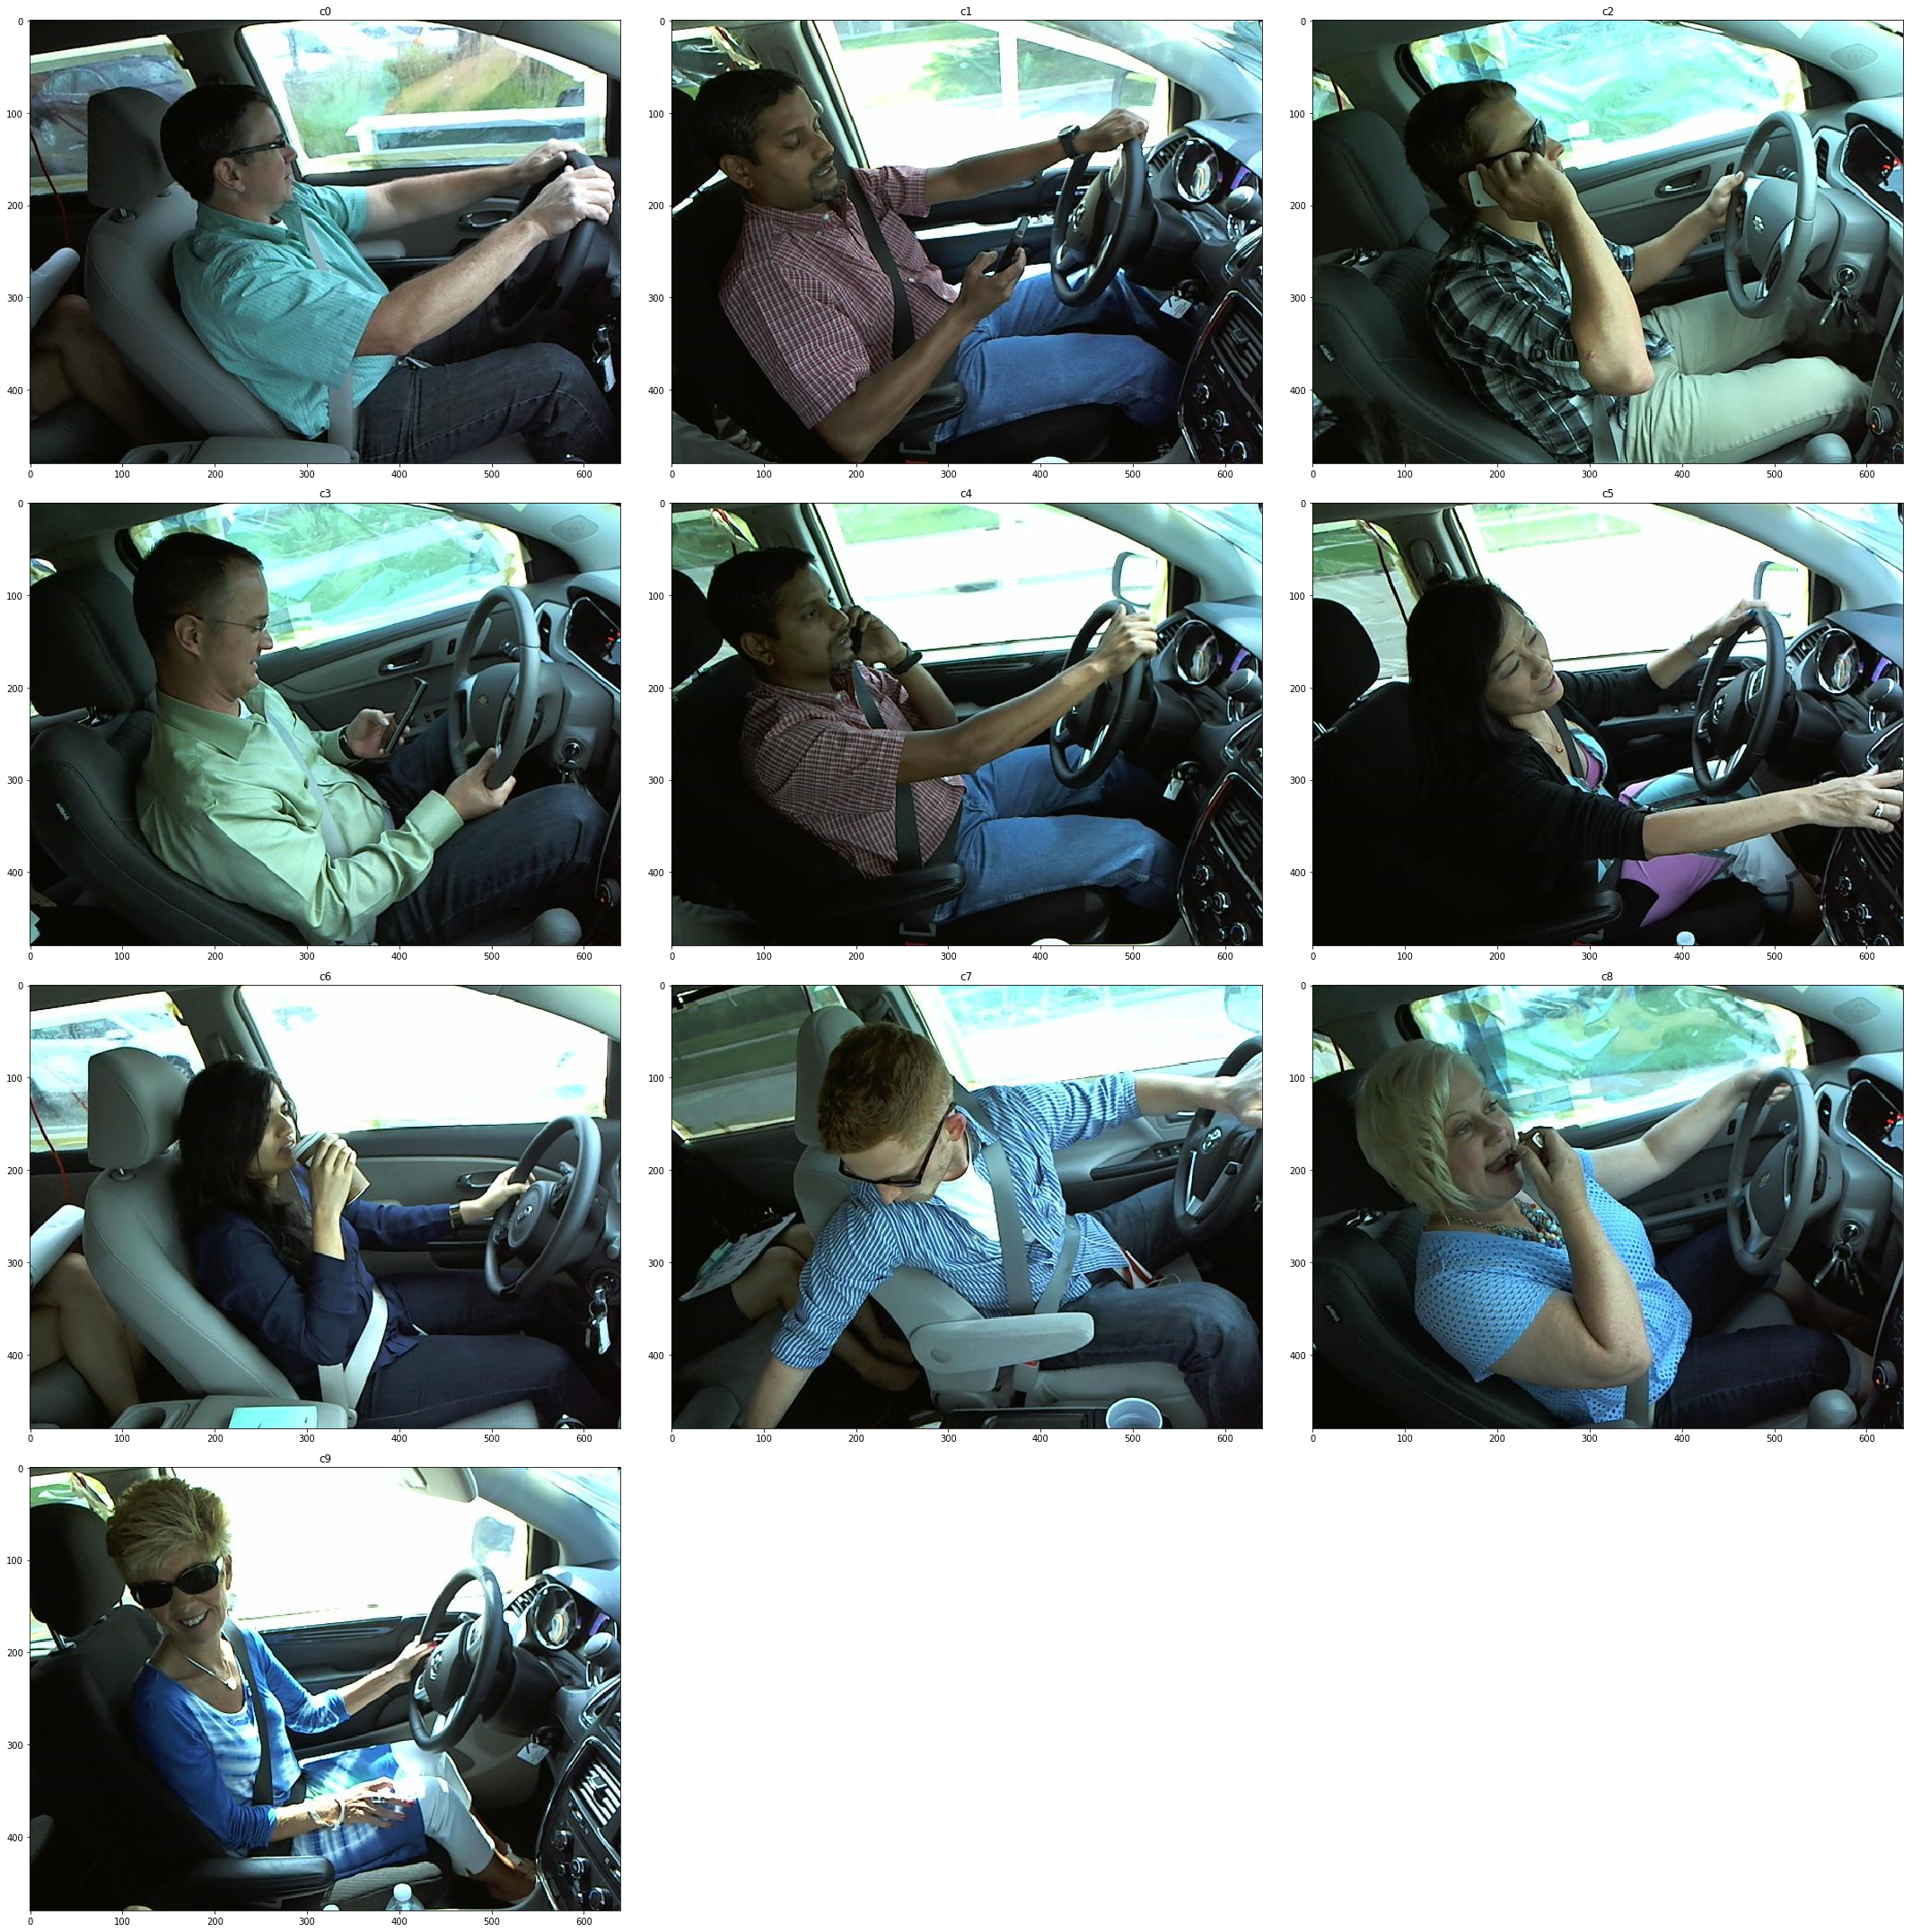

In [19]:
from keras.preprocessing.image import load_img
image_list = ['train/c0/img_609.jpg', 'train/c1/img_672.jpg', 'train/c2/img_562.jpg', 'train/c3/img_456.jpg', 'train/c4/img_503.jpg',
             'train/c5/img_56.jpg', 'train/c6/img_0.jpg', 'train/c7/img_81.jpg', 'train/c8/img_302.jpg', 'train/c9/img_50.jpg']

fig = plt.figure(figsize=(30,30))
images = []
for i in range(10):
    ax = plt.subplot(4, 3, i+1)
    img = load_img(str(data_path / image_list[i]))
    images.append(img)
    plt.imshow(img)
    ax.set_title(classes[i])
    plt.tight_layout()
    

In [20]:
images[0].height, images[0].width

(480, 640)

### 关于图片的一些观察结果：
- 每张图片大小都相同，都是640X480，都是彩色图片
- 每张图片的拍摄角度都相同，都是在司机的右前方拍摄的
- 绝大多数图片都只看到司机，看不到司机右边和后面的乘客

### 3. 我们人类如何对这些图片进行分类？

人类主要通过司机的肢体动作（头部和双手）来进行判断司机是否有走神的行为。观察图片，可以得出不同类别的图片司机的动作具有不同的特点。
- c0（没有走神）：双手紧握方向盘，眼睛正视前方或两边的后视镜。
- c1（右手发信息）：左手握方向盘，右手拿手机，低头看手机屏幕。
- c2（右手打电话）：左手握方向盘，右手拿手机放在右耳旁。
- c3（左手发信息）：跟c1类似，左右互换
- c4（左手打电话）：跟c2类似，左右互换
- c5（调收音机）：跟c1很像，身体前倾，右手往右前方伸
- c6（喝饮料）：左手握方向盘，右手拿杯子
- c7（拿后面的东西）：身体往后摆，头部有的是正的，有的向右后扭，右手伸到后面
- c8 （整理头发或化妆）：左手握方向盘，右手抚摸头发，脸部等，或者拿着口红。
- c9 （与其他乘客说话）：头部向右摆，脸部是有笑容，或嘴巴张开，呈现与人谈话时的表情。



### c8与c0，c9与c0比较容易混淆

下面的图片被分到了c9，但是我认为应该是属于c0的。

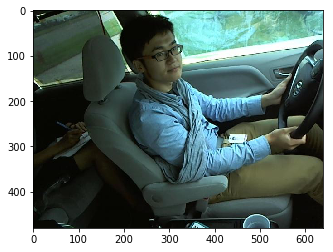

In [24]:
img = load_img(data_path / 'train/c9/img_2723.jpg')
plt.imshow(img)

下面的图片被分到了c8，但是我认为应该是属于c0的。

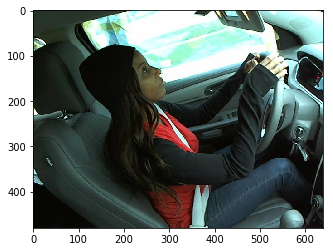

In [25]:
img = load_img(data_path / 'train/c8/img_2378.jpg')
plt.imshow(img)

### 4. 如何实施？
通过前面的分析，我知道了图片的关注点（Attention）主要是人（还有一些像方向盘、手机、饮料、口红等物品），对分类起决定作用的是人的姿态，特别是头部和手部。如果使用预训练模型的话，要注意ImageNet数据集与本项目数据集存在着比较大的差异，可能需要放开更多的层。

另外一点是，本项目所有图片的拍摄角度都相同，对图片做数据增强的时候，最好不要使用旋转，以免对网络产生误导，增加分类的难度。